# Copenhagen Social Network Analysis

April 26th, 2025. Universitat de Barcelona

_By Iris Vukovic and Caterina Fuses_

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import networkx as nx
import numpy as np
import itertools
from sklearn.linear_model import LinearRegression


## Load Dataset

In the Copenhagen Networks study [1] we have 4 different data sources representing different modalities of social interactions between 706 students in a university: calls, sms, facebooks friends, and bluetooth proximity. We have the data stored as adjacency lists. 

In [2]:
DATA_DIR = "./"
DATA_FILENAMES = {"bluetooth": "bt_symmetric.csv",
                  "calls": "calls.csv",
                  "sms": "sms.csv",
                  "facebook_friends": "fb_friends.csv",
                  "genders": "genders.csv"}

In [3]:
def LoadData(data_filename, data_dir):
  '''Loads data from |data_dir|/|data_filename|. Returns Pandas dataframe.'''
  return pd.read_csv(os.path.join(data_dir, data_filename))

In [4]:
df_bt = LoadData(DATA_FILENAMES["bluetooth"], DATA_DIR)
print("bluetooth\n", df_bt.head())

df_calls = LoadData(DATA_FILENAMES["calls"], DATA_DIR)
# Filter irregular entries
df_calls = df_calls[df_calls['duration'] > 0]
print("\ncalls\n", df_calls.head())

df_sms = LoadData(DATA_FILENAMES["sms"], DATA_DIR)
print("\nsms\n", df_sms.head())

df_facebook_friends = LoadData(DATA_FILENAMES["facebook_friends"], DATA_DIR)
print("\nfacebook friends\n", df_facebook_friends.head())

df_genders = LoadData(DATA_FILENAMES["genders"], DATA_DIR)
print("\ngenders\n", df_genders.head())

bluetooth
    # timestamp  user_a  user_b  rssi
0            0       0      -1     0
1            0       1      -1     0
2            0       2      -1     0
3            0       3      -2   -88
4            0       5      -1     0

calls
    timestamp  caller  callee  duration
0        184     300     301       121
1       3920     512     299       670
2       5623     301     300       504
4      15466     512       0         5
5      15497     512       0        28

sms
    timestamp  sender  recipient
0         18     370        512
1         37     512        370
2        126     370        512
3        134       0        512
4        312     137        136

facebook friends
    # user_a  user_b
0         0     512
1         0     263
2         0     525
3         0     285
4         0     543

genders
    # user  female
0       0       0
1       2       0
2       3       0
3       4       0
4       5       0


In [5]:
#unique nodes in bluetooth
users_bt = pd.unique(df_bt[["user_a", "user_b"]].values.ravel())
num_nodes_bt = len(users_bt)
edges_bt = df_bt[["user_a", "user_b"]].drop_duplicates()
num_edges_bt = len(edges_bt)

#unique nodes in calls
users_calls = pd.unique(df_calls[["caller", "callee"]].values.ravel())
num_nodes_calls = len(users_calls)
edges_calls = df_calls[["caller", "callee"]].drop_duplicates()
num_edges_calls = len(edges_calls)

#unique nodes in facebook friends
users_fb = pd.unique(df_facebook_friends[["# user_a", "user_b"]].values.ravel())
num_nodes_fb = len(users_fb)
edges_fb = df_facebook_friends[["# user_a", "user_b"]].drop_duplicates()
num_edges_fb = len(edges_fb)

# Unique nodes in sms
users_sms = pd.unique(df_sms[["sender", "recipient"]].values.ravel())
num_nodes_sms = len(users_sms)
edges_sms = df_sms[["sender", "recipient"]].drop_duplicates()
num_edges_sms = len(edges_sms)

In [6]:
# Create a dictionary with the data
dataset_descriptors = {
    "Dataset": ["Bluetooth", "Calls", "Facebook Friends", "SMS"],
    "Number of Nodes": [num_nodes_bt, num_nodes_calls, num_nodes_fb, num_nodes_sms],
    "Number of Edges": [num_edges_bt, num_edges_calls, num_edges_fb, num_edges_sms]
}

# Convert the dictionary into a DataFrame
dataset_descriptors = pd.DataFrame(dataset_descriptors)
dataset_descriptors

Dataset  Number of Nodes  Number of Edges
0         Bluetooth              708            80886
1             Calls              504              811
2  Facebook Friends              800             6429
3               SMS              568             1303

We don't have the same number of nodes in all datasets, maybe not all students participating in the study sent sms or called anyone during the length of the study.

## Graph visualization

The calls dataset has a temporal dimension which we wish to explore. For that, we will subset the dataset into 4 weeks, obtaining a graph for each week.

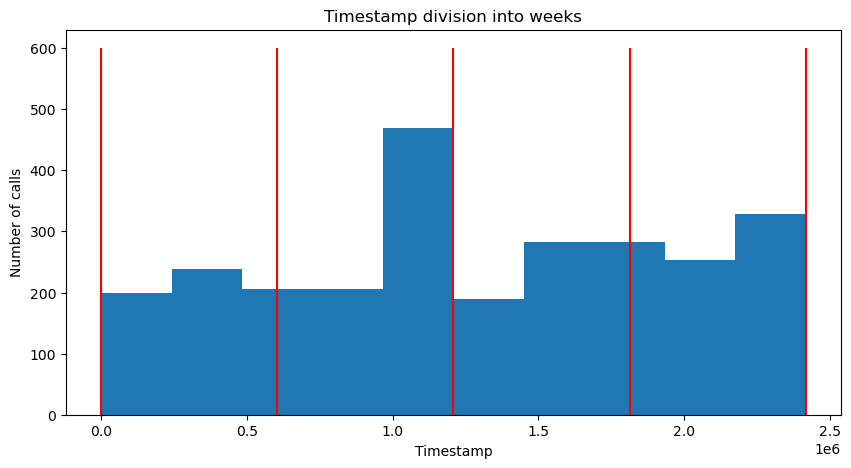

In [7]:
# Create timestamp bins into weeks
end_time = df_calls['timestamp'].max()
week_bins = [0]
for week in range(1,5):
  week_bins.append(week_bins[-1] + int(end_time/4))

# Plot timestamp division
times = df_calls['timestamp'].values
plt.figure(figsize=(10, 5))
plt.hist(times)
for week in week_bins:
  plt.vlines(week, 0, 600, colors = 'red') # red vertical lines represent week division
plt.title("Timestamp division into weeks")
plt.xlabel("Timestamp")
plt.ylabel("Number of calls")
plt.show()  

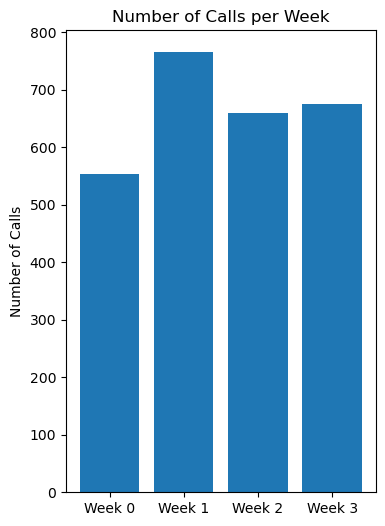

In [8]:
# Use pd.cut to create the 'week' column based on week_bins
df_calls['week'] = pd.cut(df_calls['timestamp'], bins=week_bins, labels=range(len(week_bins) - 1), right=False)

# Plot calls per week
plt.figure(figsize=(4, 6))
plt.hist(df_calls['week'], bins=range(len(week_bins)), align='left', rwidth=0.8)
plt.xticks(range(len(week_bins) - 1), [f"Week {i}" for i in range(len(week_bins) - 1)])
plt.ylabel('Number of Calls')
plt.title('Number of Calls per Week')
plt.show()

In [9]:
# Dictionary to store weekly graphs
graphs_by_week = {}
# Dataframe with final graph structure
adj_list = pd.DataFrame(columns=['week', 'caller', 'callee', 'n_calls'])

for week, group in df_calls.groupby('week', observed=False): 
    G_calls = nx.DiGraph()

    for _, row in group.iterrows():
        caller = int(row['caller'])
        callee = int(row['callee'])

        if G_calls.has_edge(caller, callee):
            G_calls[caller][callee]['weight'] += 1  # Increment weight by 1 for each occurrence
        else:
            G_calls.add_edge(caller, callee, weight=1)  # Initialize weight as 1

    # Store the graph in the dictionary using the week as the key
    graphs_by_week[week] = G_calls

    # Store adjacency list
    adj_list_week = pd.DataFrame(group.groupby(['caller', 'callee']).size(), columns=['n_calls']).reset_index()
    adj_list_week['week'] = week
    adj_list = pd.concat([adj_list, adj_list_week], ignore_index=True)

# Convert n_calls to numeric
adj_list['n_calls'] = pd.to_numeric(adj_list['n_calls'], errors='coerce')

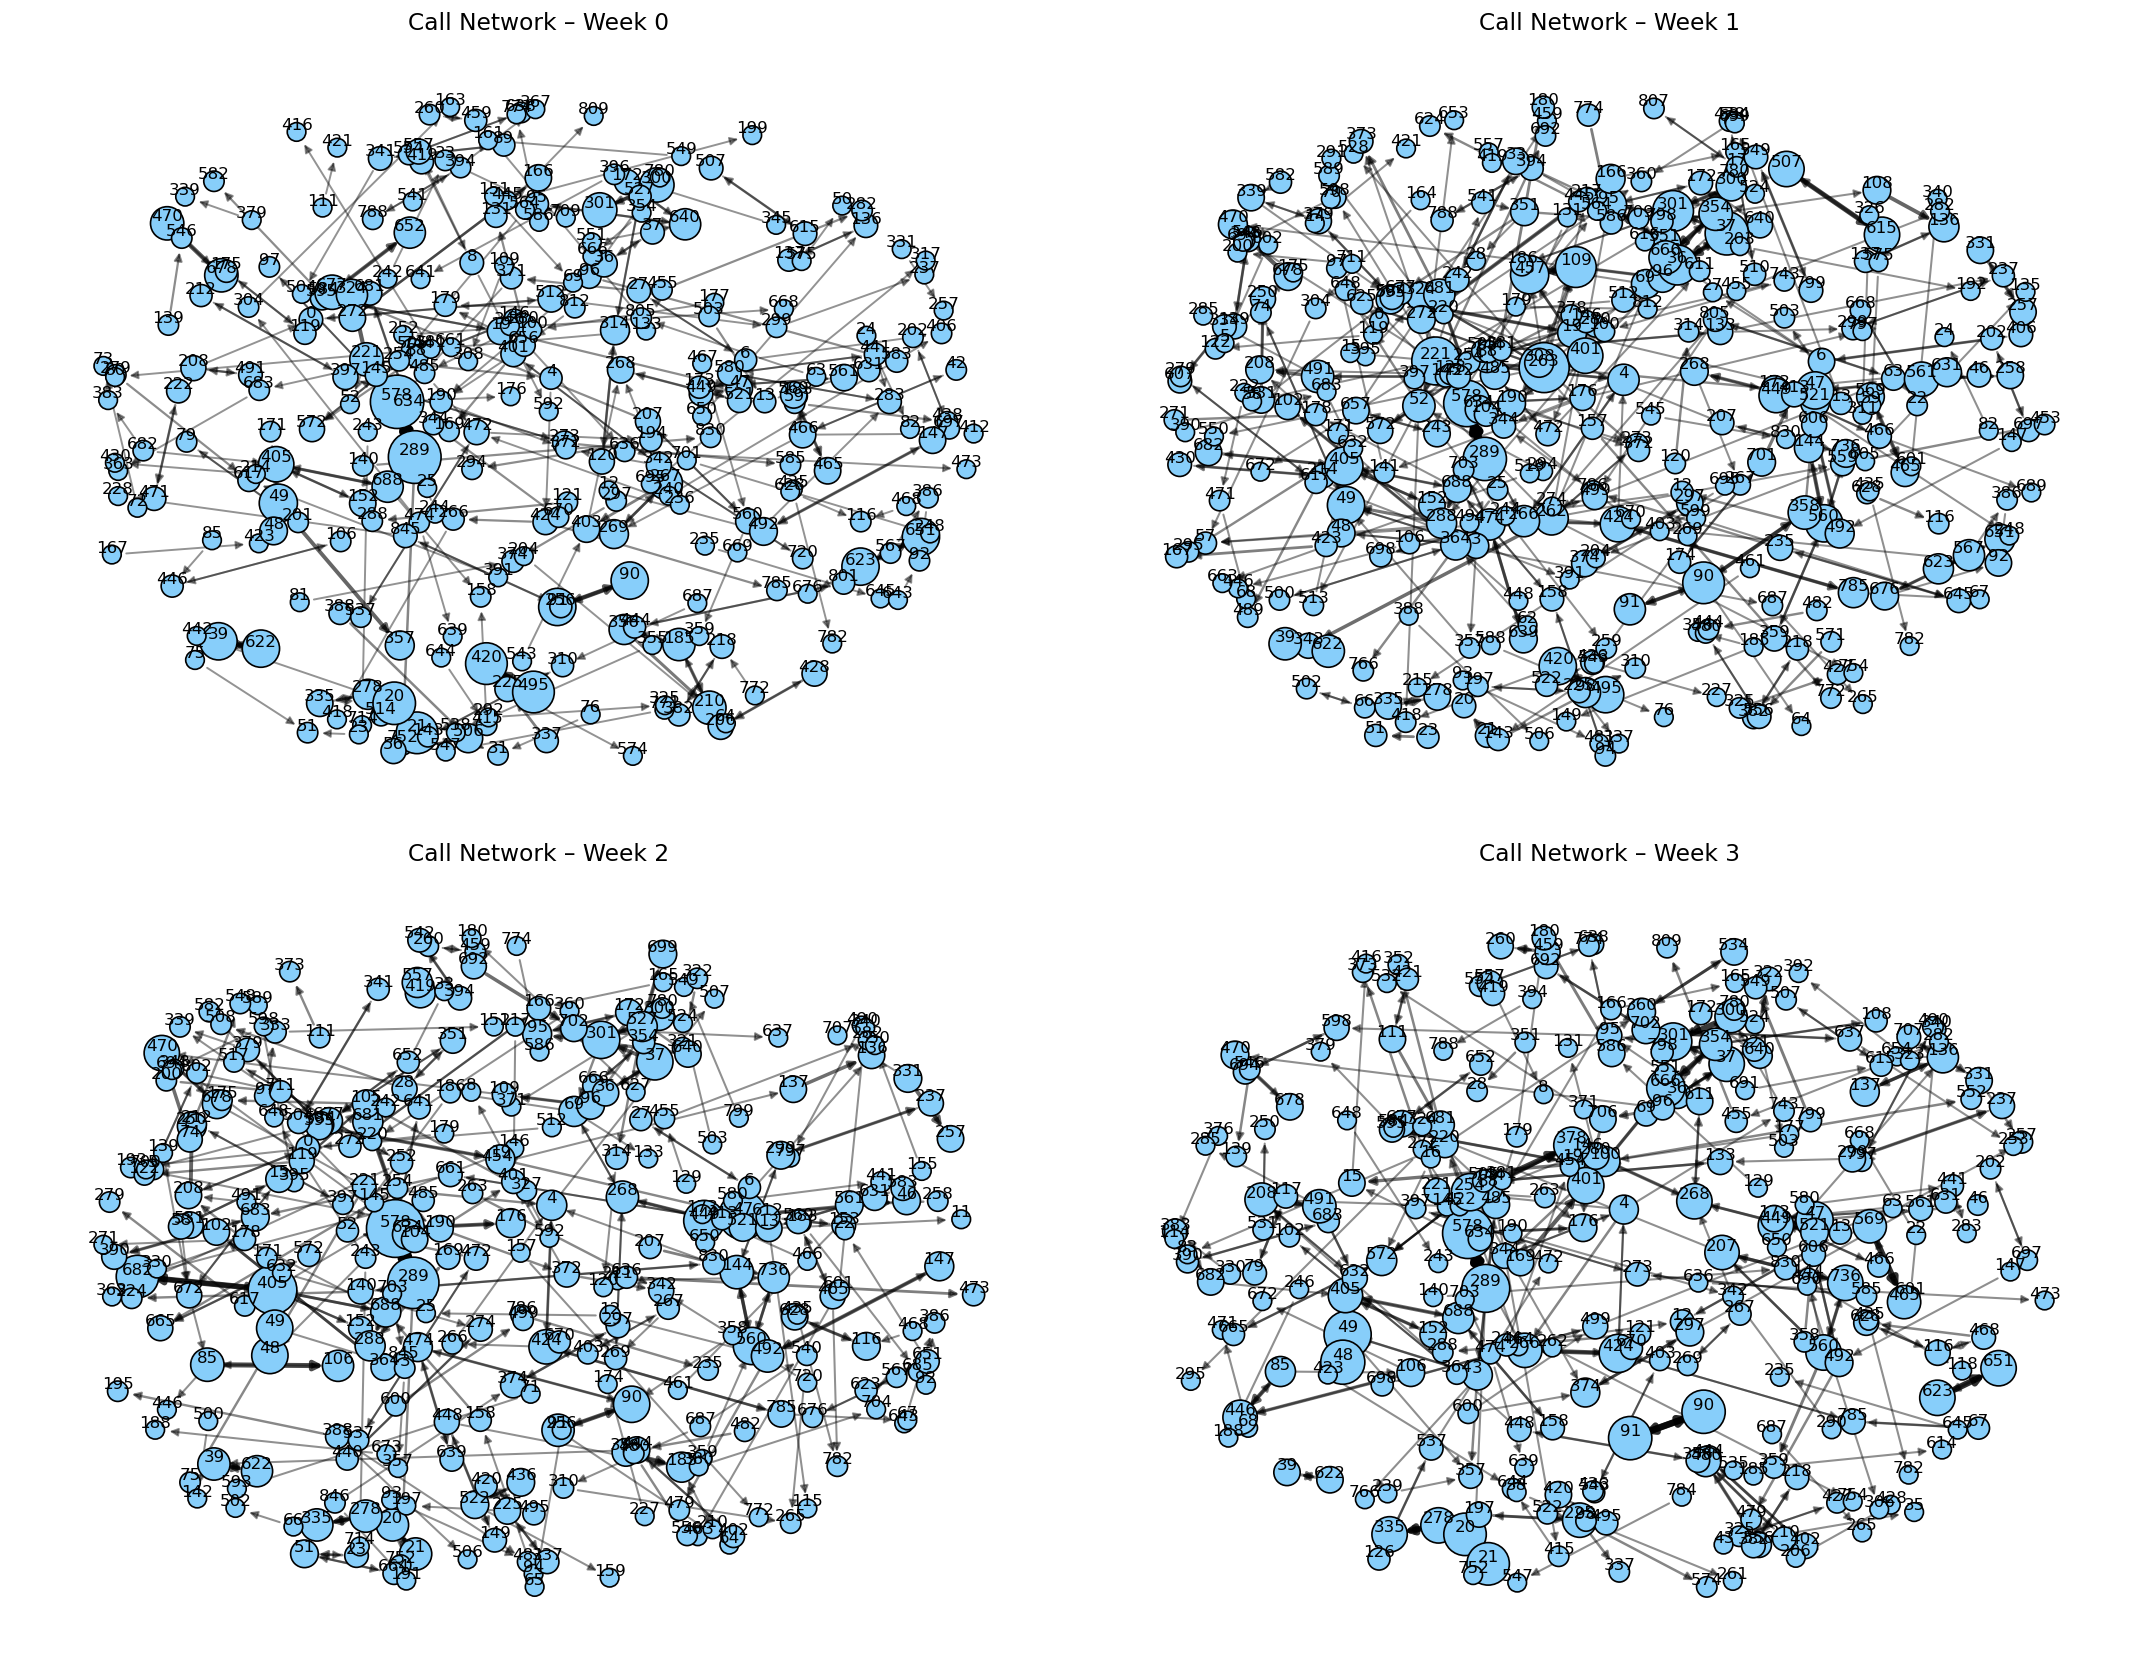

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14), dpi=120)
axes = axes.flatten()

# Reuse the same master layout
master = nx.compose_all([g for g in graphs_by_week.values()])
pos_master = nx.spring_layout(master, seed=42, k=0.25, weight='weight')

for ax, (week, G) in zip(axes, graphs_by_week.items()):
    # Compute node sizes based on degree
    degrees = dict(G.degree(weight='weight'))
    node_size = [100 + 25*degrees[n] for n in G]

    weights = np.array([d['weight'] for _, _, d in G.edges(data=True)])
    widths = 1 + 4 * weights / weights.max()

    nx.draw_networkx_nodes(G, pos_master, ax=ax,
                           node_size=node_size,
                           node_color='lightskyblue',
                           edgecolors='black')
    nx.draw_networkx_edges(G, pos_master, ax=ax,
                           width=widths, arrows=True,
                           alpha=0.4 + 0.6 * weights / weights.max())
    nx.draw_networkx_labels(G, pos_master, ax=ax,
                            font_size=10, verticalalignment='bottom')

    ax.set_title(f"Call Network – Week {week}", fontsize=14)
    ax.axis('off')

plt.tight_layout()
plt.show()

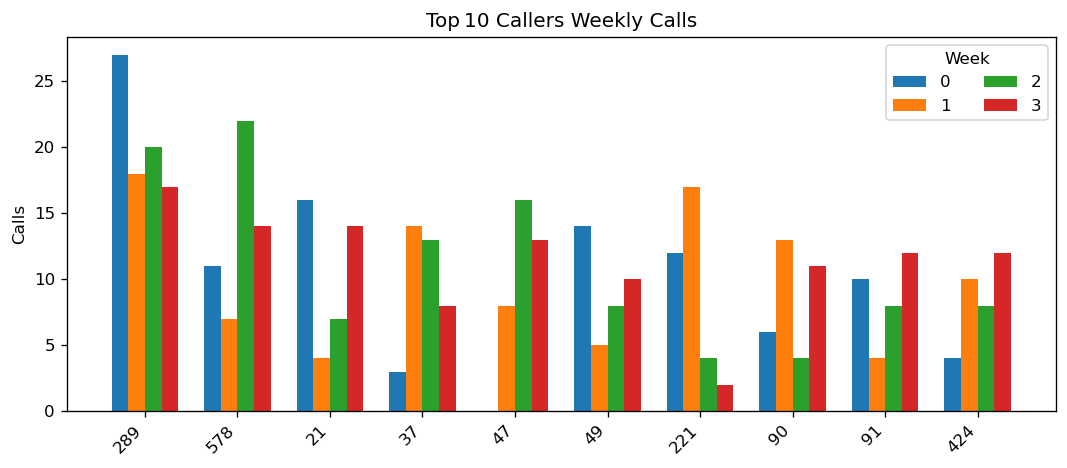

In [11]:
weeks = [0, 1, 2, 3]           
top10 = (adj_list.groupby('caller', observed=False)['n_calls'] 
           .sum()
           .nlargest(10)
           .index)

pivot = (adj_list[adj_list.caller.isin(top10)]
           .groupby(['caller', 'week'], observed=False)['n_calls']
           .sum()
           .unstack(fill_value=0)
           .reindex(columns=weeks, fill_value=0)
           .loc[top10])  

w, x = 0.18, range(len(pivot))
fig, ax = plt.subplots(figsize=(9,4), dpi=120)
for i, wk in enumerate(weeks):
    ax.bar([p+i*w for p in x], pivot[wk], w, label=f"{wk}")

ax.set_xticks([p+1.5*w for p in x])
ax.set_xticklabels(pivot.index, rotation=45, ha='right')
ax.set_ylabel('Calls'); ax.set_title('Top 10 Callers Weekly Calls')
ax.legend(ncol=2, title='Week')
plt.tight_layout()
plt.show()

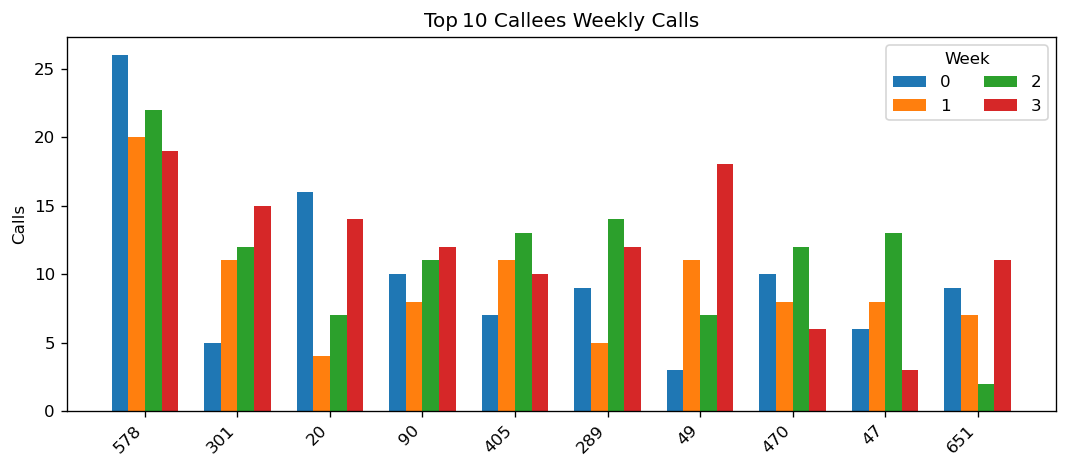

In [12]:
top10 = (adj_list.groupby('callee', observed=False)['n_calls'] 
           .sum()
           .nlargest(10)
           .index)

pivot = (adj_list[adj_list.callee.isin(top10)]
           .groupby(['callee', 'week'], observed=False)['n_calls']
           .sum()
           .unstack(fill_value=0)
           .reindex(columns=weeks, fill_value=0)
           .loc[top10])  

w, x = 0.18, range(len(pivot))
fig, ax = plt.subplots(figsize=(9,4), dpi=120)
for i, wk in enumerate(weeks):
    ax.bar([p+i*w for p in x], pivot[wk], w, label=f"{wk}")

ax.set_xticks([p+1.5*w for p in x])
ax.set_xticklabels(pivot.index, rotation=45, ha='right')
ax.set_ylabel('Calls'); ax.set_title('Top 10 Callees Weekly Calls')
ax.legend(ncol=2, title='Week')
plt.tight_layout()
plt.show()

## Microscale descriptors

### Centrality

The previous plots can be thought of the in and out centralities of nodes. We can calculate the number of calls a person makes and recieves with the out and in degree centrality. Degree centrality is the mean between the two, which gives us 

In [13]:
# Empty list to store centrality measures for each week
centrality_weeks = []

for week, G_calls in graphs_by_week.items():

    # Compute centrality measures
    degree_centrality = nx.degree_centrality(G_calls)
    in_degrees = dict(G_calls.in_degree())
    out_degrees = dict(G_calls.out_degree())
    closeness_centrality = nx.closeness_centrality(G_calls)
    betweenness_centrality = nx.betweenness_centrality(G_calls)
    eigenvector_centrality = nx.eigenvector_centrality(G_calls, max_iter=500, tol=1e-06) 
    katz_centrality = nx.katz_centrality(G_calls, alpha=0.1)

    degree_centrality = centrality_weeks.append({
        'week': week,
        'degree_centrality': degree_centrality,
        'in_degrees': in_degrees,
        'out_degrees': out_degrees,
        'closeness_centrality': closeness_centrality,
        'betweenness_centrality': betweenness_centrality,
        'eigenvector_centrality': eigenvector_centrality,
        'katz_centrality': katz_centrality
    })
# Convert the list of dictionaries to dataframe
centrality_weeks = pd.DataFrame(centrality_weeks)

In [25]:
def plot_weekly_graphs_by_centrality(graphs_by_week, centrality_df, centrality_key):
    """
    Plots a 2x2 grid of weekly graphs colored by a specified centrality measure.
    
    Parameters:
    - graphs_by_week: dict of week -> NetworkX graph
    - centrality_df: DataFrame with 'week' and centrality measure per week (as dict)
    - centrality_key: str, column name in centrality_df to use for node coloring
    """
    # Compose master layout for consistent positioning
    master = nx.compose_all([g for g in graphs_by_week.values()])
    pos_master = nx.spring_layout(master, seed=42, k=0.3, weight='weight')

    fig, axs = plt.subplots(2, 2, figsize=(14, 12), dpi=120)
    axs = axs.flatten()

    for i, (week, G) in enumerate(graphs_by_week.items()):

        # Filter nodes with degree > 2
        degrees_total = dict(G.degree())
        nodes_to_keep = [n for n, d in degrees_total.items() if d > 2]
        G_filtered = G.subgraph(nodes_to_keep).copy()

        # Get centrality dict for this week
        centrality_row = centrality_df.loc[centrality_df['week'] == week]
        centrality_dict = centrality_row.iloc[0][centrality_key]
        # Get centrality values for nodes in the filtered graph
        centrality_vals = np.array([centrality_dict.get(n, 0) for n in G_filtered.nodes()])
        
        # Normalize centrality values for size and color
        norm_centrality = centrality_vals / (centrality_vals.max() + 1e-6)  # avoid divide by zero

        # Node color and size both reflect centrality
        node_colors = norm_centrality
        node_size = 300 * norm_centrality + 100  # scale sizes

        weights = np.array([d['weight'] for _, _, d in G_filtered.edges(data=True)])
        widths = 1 + 4 * weights / weights.max()

        # Draw graph
        nx.draw_networkx_nodes(G_filtered, pos_master, ax=axs[i],
                               node_size=node_size,
                               node_color=node_colors,
                               cmap='bwr',
                               edgecolors='black')
        nx.draw_networkx_edges(G_filtered, pos_master, ax=axs[i],
                               width=widths, arrows=True,
                               alpha=0.4 + 0.6 * weights / weights.max())
        nx.draw_networkx_labels(G_filtered, pos_master, ax=axs[i],
                                font_size=10, verticalalignment='bottom')

        axs[i].set_title(f"Week {week} – {centrality_key}", fontsize=14)
        axs[i].axis('off')

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()

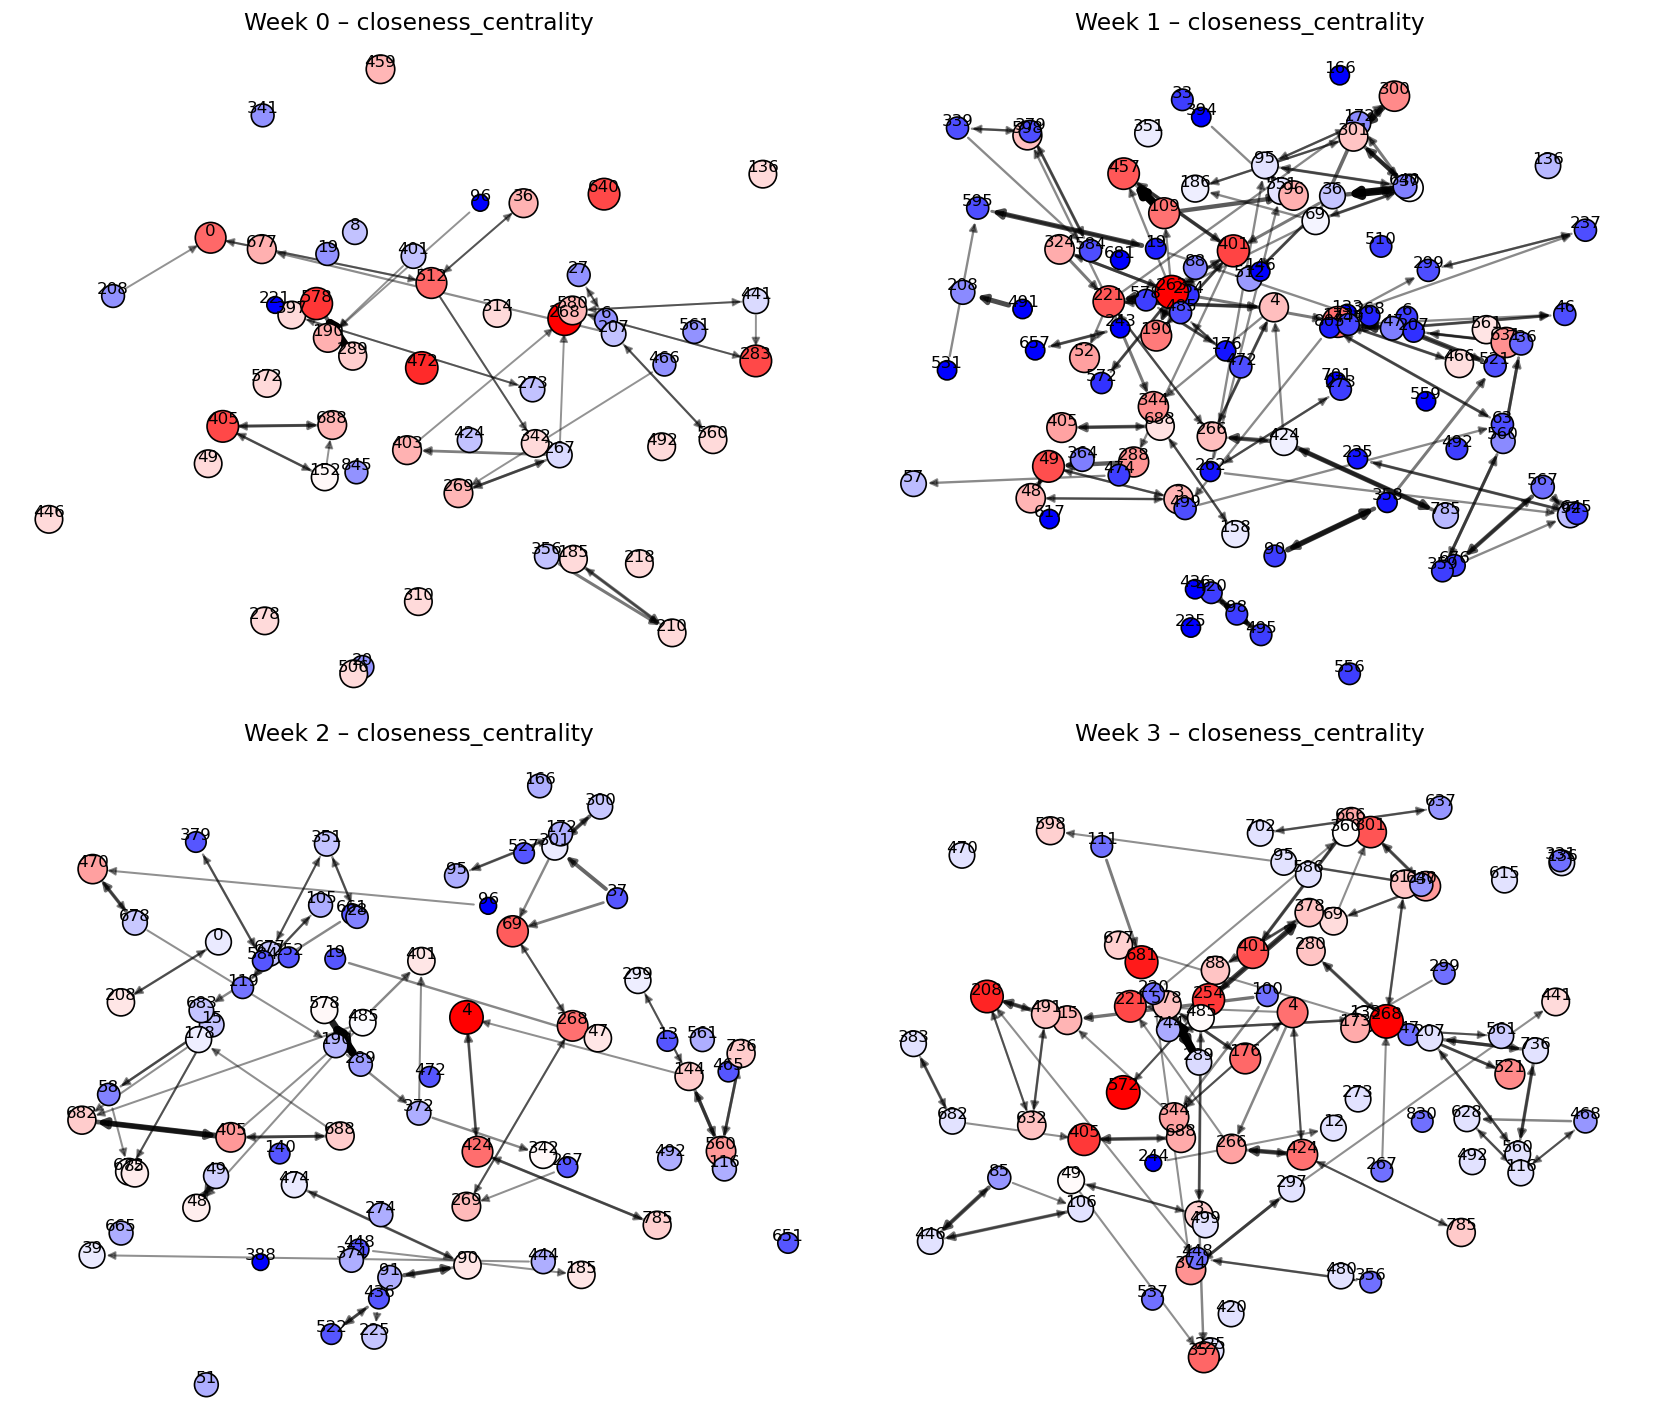

In [26]:
plot_weekly_graphs_by_centrality(graphs_by_week, centrality_weeks, 'closeness_centrality')

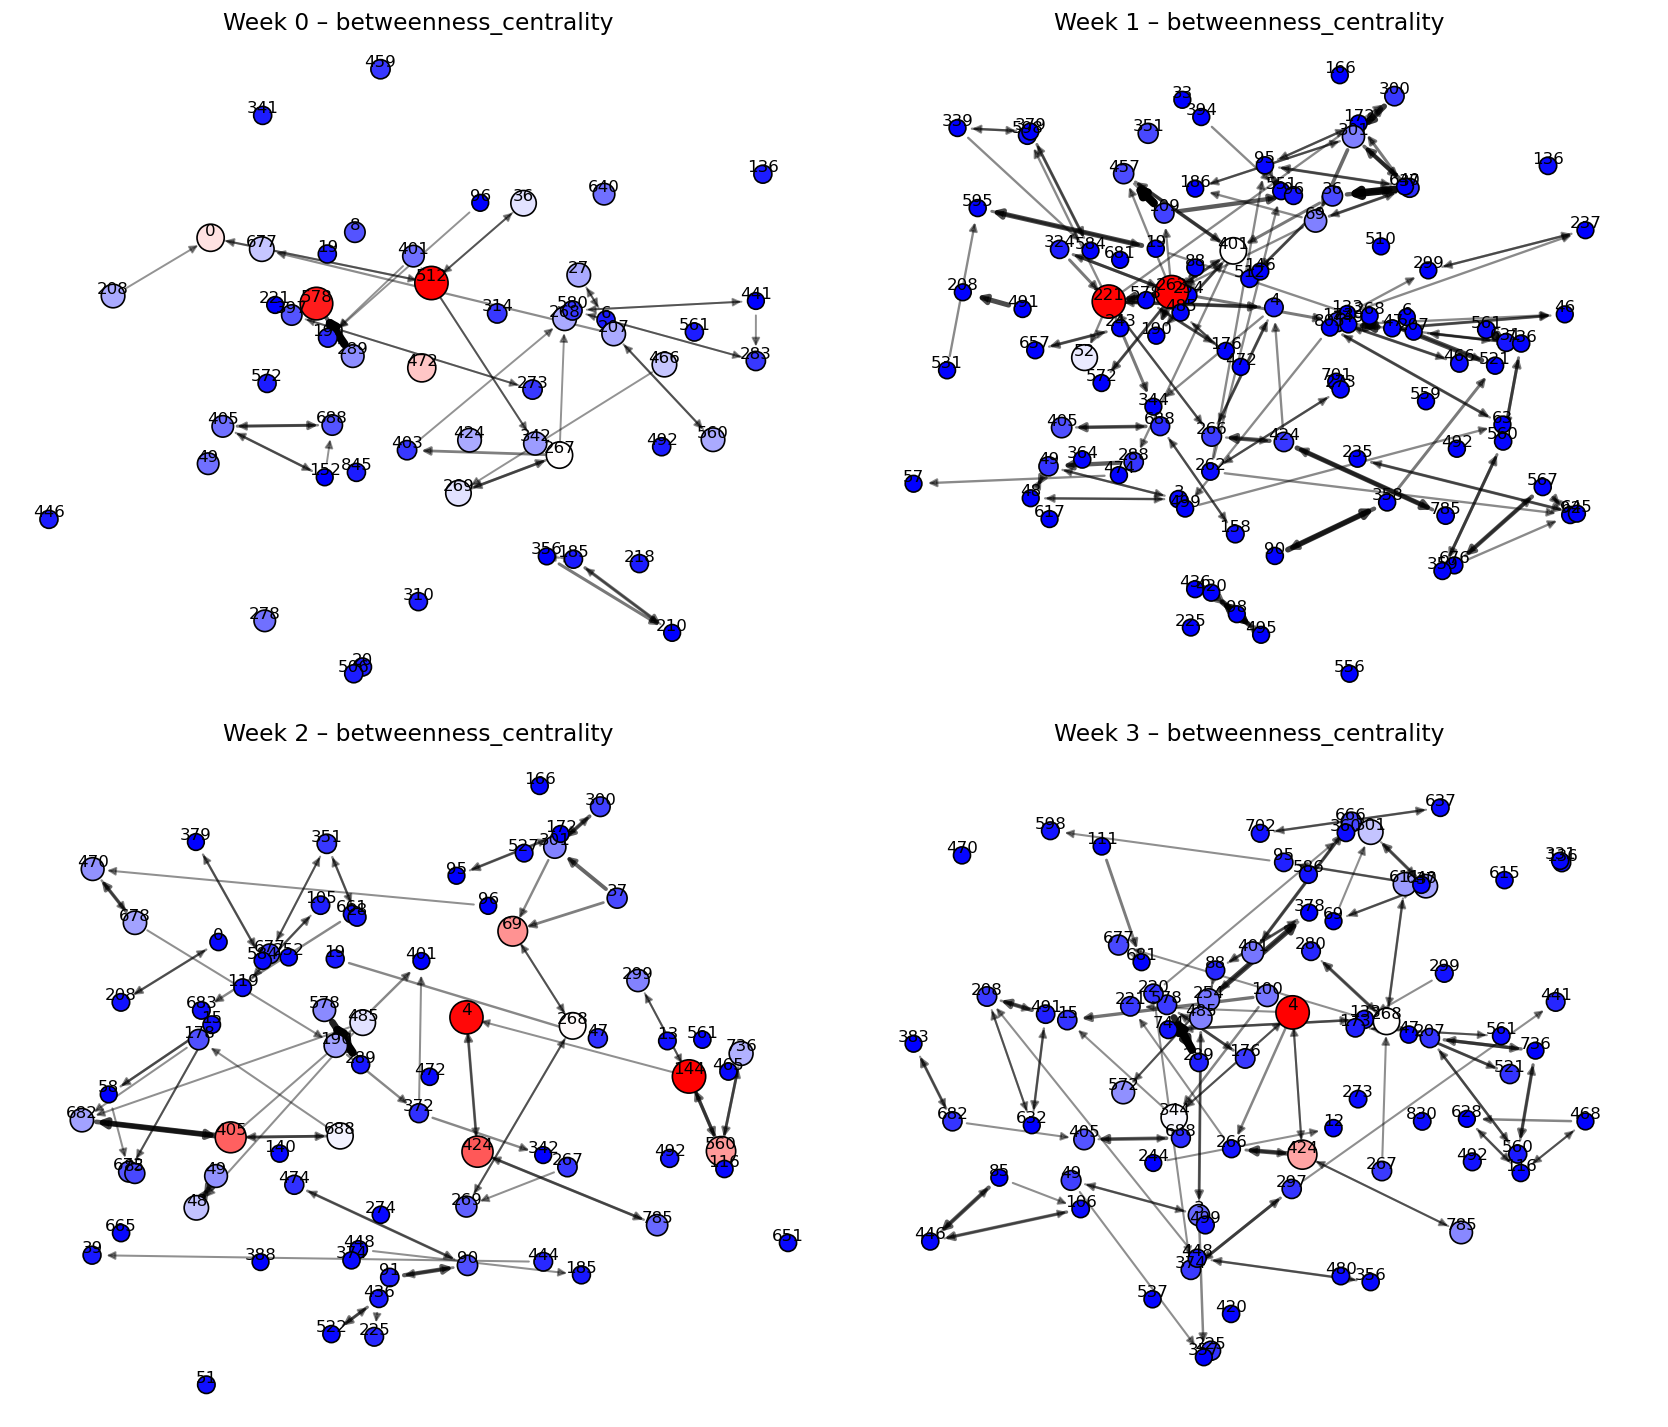

In [27]:
plot_weekly_graphs_by_centrality(graphs_by_week, centrality_weeks, 'betweenness_centrality')

Let's plot all centralities from week 1:

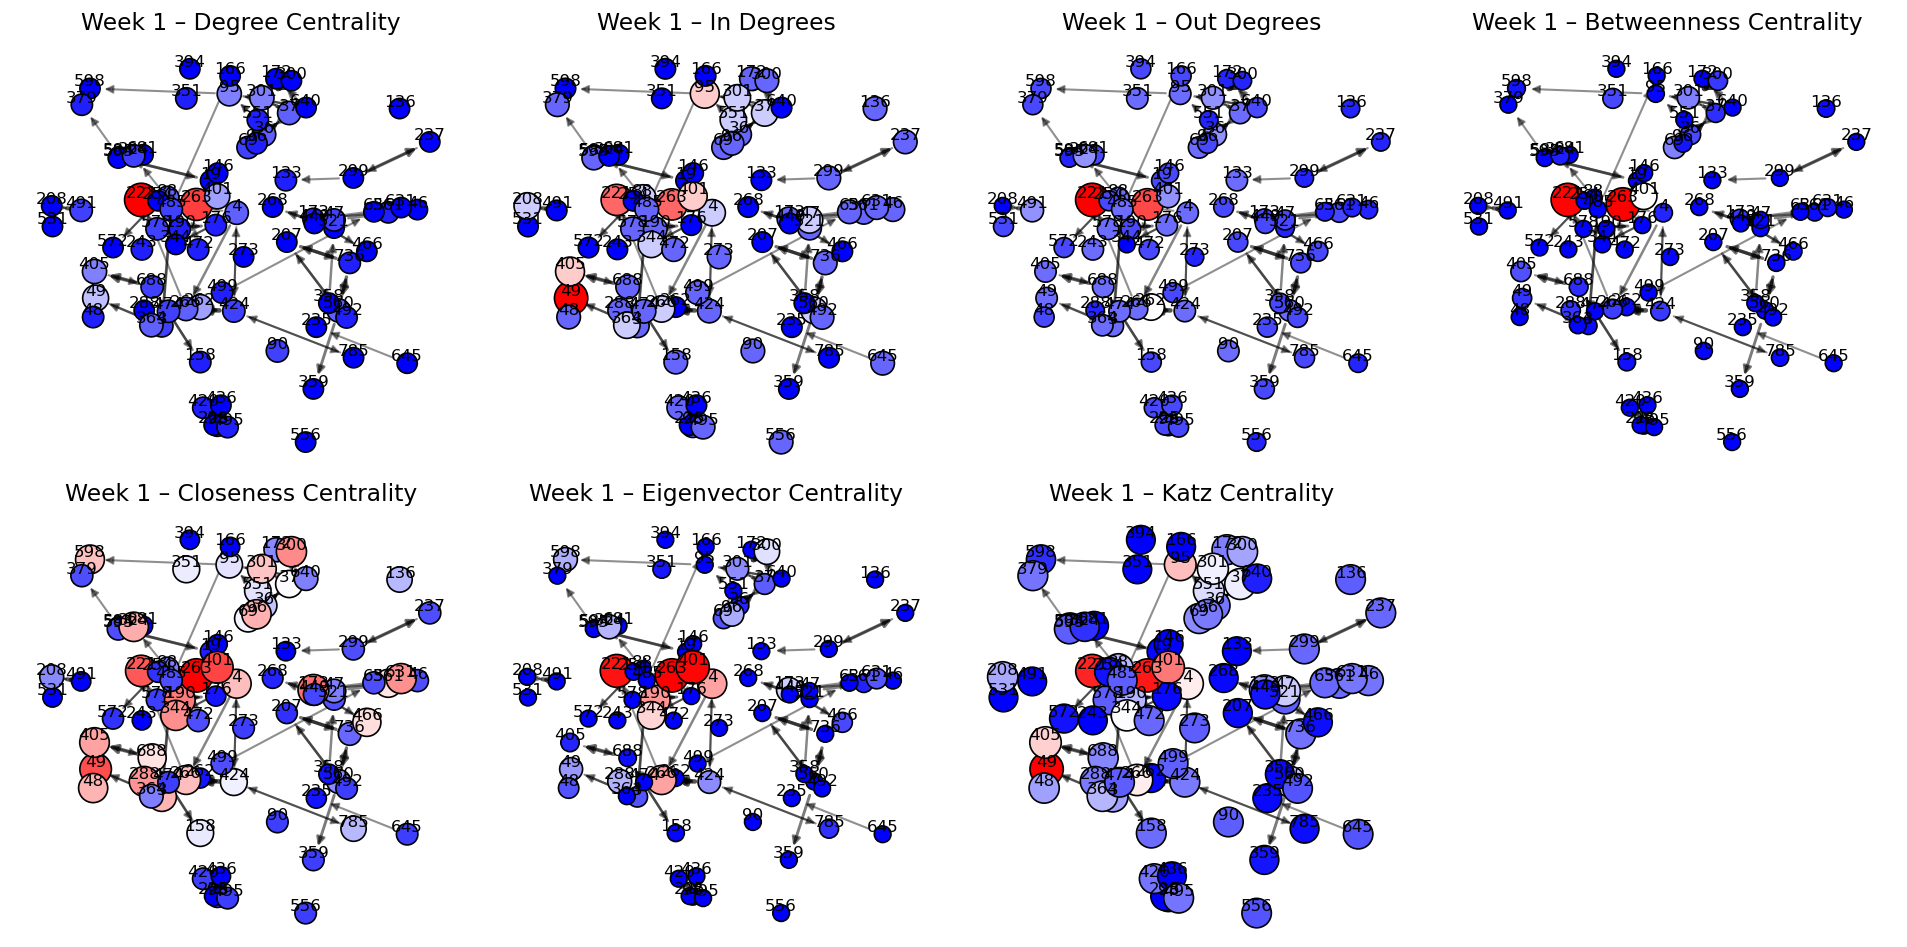

In [17]:
# Get the graph for Week 1
G_week_1 = graphs_by_week[1]
# Filter nodes with degree > 2
degrees_total = dict(G_week_1.degree())
nodes_to_keep = [n for n, d in degrees_total.items() if d > 2]
G_week_1 = G.subgraph(nodes_to_keep).copy()

# Define centrality measures to plot
centrality_keys = ['degree_centrality', 'in_degrees', 'out_degrees', 'betweenness_centrality', 'closeness_centrality', 'eigenvector_centrality', 'katz_centrality']

fig, axs = plt.subplots(2, 4, figsize=(16,8), dpi=120)
axs = axs.flatten()

for i, centrality_key in enumerate(centrality_keys):
   
    # Get centrality values for Week 1
    centrality_row = centrality_weeks.loc[centrality_weeks['week'] == 1]
    
    # Extract centrality values for nodes
    centrality_dict = centrality_row.iloc[0][centrality_key]
    centrality_vals = np.array([centrality_dict.get(n, 0) for n in G_week_1.nodes()])
    node_colors = centrality_vals / centrality_vals.max()

    # Normalize centrality values for size and color
    norm_centrality = centrality_vals / (centrality_vals.max() + 1e-6)  # avoid divide by zero

    # Node color and size both reflect centrality
    node_colors = norm_centrality
    node_size = 300 * norm_centrality + 100  # scale sizes

    # Edge width based on weight (for visual clarity)
    weights = np.array([d['weight'] for _, _, d in G_week_1.edges(data=True)])
    widths = 1 + 4 * weights / weights.max()

    # Plot the graph with nodes colored by the current centrality measure
    nx.draw_networkx_nodes(G_week_1, pos_master, ax=axs[i],
                            node_size=node_size,
                            node_color=node_colors,
                            cmap='bwr', edgecolors='black')
    nx.draw_networkx_edges(G_week_1, pos_master, ax=axs[i],
                            width=widths, arrows=True,
                            alpha=0.4 + 0.6 * weights / weights.max())
    nx.draw_networkx_labels(G_week_1, pos_master, ax=axs[i],
                            font_size=10, verticalalignment='bottom')

    axs[i].set_title(f"Week 1 – {centrality_key.replace('_', ' ').title()}", fontsize=14)
    axs[i].axis('off')

# Hide extra axes (those beyond the number of centrality measures)
for j in range(len(centrality_keys), len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

As seen by closeness centrality, there are many nodes that are close to other nodes in teh network, indicating that our network is not highly centralized and many people are clsoely connected to each other. Node 221 and 268 stand out in every measure of centrality, so this person is potentially present in many shortest paths between nodes.

### Shortest paths

In [18]:
for week, G_calls in graphs_by_week.items():
        
    # Compute all shortest paths TO the top callee
    shortest_paths_to_top = {}
    path_lengths = []

    print(f"\nTop callees in week {week}:")
    
    for node in G_calls.nodes:
        # Get top callee for the current week
        group = df_calls[df_calls['week'] == week]  # Filter the DataFrame for the current week
        top_callees = group['callee'].value_counts()
        top_callee = top_callees.idxmax()  # Get the most frequent callee
        print(top_callees.head(10))
        print(f"Top callee of the week: {top_callee}")
        
        if node == top_callee:
            continue
        try:
            path = nx.shortest_path(G_calls, source=node, target=top_callee)
            length = nx.shortest_path_length(G_calls, source=node, target=top_callee)
            shortest_paths_to_top[node] = (path, length)
            path_lengths.append(length)
        except nx.NetworkXNoPath:
            continue  # Skip if there's no path

    # Print shortest paths and lengths for each node
    if shortest_paths_to_top:
        print(f"Shortest paths TO top callee '{top_callee}':\n")
        for source, (path, length) in shortest_paths_to_top.items():
            print(f" - {source} → {path} (Length: {length})")
        print()
    else:
        print(f"No reachable paths to '{top_callee}' this week.\n")

    # Compute average shortest path length to top callee (ignores unreachable nodes)
    if path_lengths:
        avg_path_length = np.mean(path_lengths)
        print(f"Average shortest path length to '{top_callee}': {avg_path_length:.2f}")
    else:
        print(f"No reachable paths to '{top_callee}' this week.\n")


Top callees in week 0:
callee
578    26
20     16
420    12
210    11
622    11
324    10
90     10
470    10
651     9
289     9
Name: count, dtype: int64
Top callee of the week: 578
callee
578    26
20     16
420    12
210    11
622    11
324    10
90     10
470    10
651     9
289     9
Name: count, dtype: int64
Top callee of the week: 578
callee
578    26
20     16
420    12
210    11
622    11
324    10
90     10
470    10
651     9
289     9
Name: count, dtype: int64
Top callee of the week: 578
callee
578    26
20     16
420    12
210    11
622    11
324    10
90     10
470    10
651     9
289     9
Name: count, dtype: int64
Top callee of the week: 578
callee
578    26
20     16
420    12
210    11
622    11
324    10
90     10
470    10
651     9
289     9
Name: count, dtype: int64
Top callee of the week: 578
callee
578    26
20     16
420    12
210    11
622    11
324    10
90     10
470    10
651     9
289     9
Name: count, dtype: int64
Top callee of the week: 578
callee
578

Average shortest path to the top callee is usually around 1, so most people who call 578 are in direct communication with them and don´t need to go through many other people to reach them

## Macroscale descriptors

Calculating distances in the calls graphs is not straight forward, as they are not strongly connected. We can take the largest strongly connected components.

In [19]:
weekly_macro_distances = []

for week, G in graphs_by_week.items():
    # Pick connected subgraph
    sccs = list(nx.strongly_connected_components(G))
    if not sccs:
        continue

    Gc = G.subgraph(max(sccs, key=len)).copy()
    n_nodes = Gc.number_of_nodes()
    n_edges = Gc.number_of_edges()

    weekly_macro_distances.append({
        'week':        week,
        'n_nodes'     : n_nodes,
        'n_edges'     : n_edges,
        'center':      nx.center(Gc),
        'diameter':    nx.diameter(Gc),
        'eccentricity':nx.eccentricity(Gc),
        'periphery':   nx.periphery(Gc),
        'radius':      nx.radius(Gc)
    })

weekly_macro_distances = pd.DataFrame(weekly_macro_distances)
weekly_macro_distances


week  n_nodes  n_edges      center  diameter  \
0     0        4        6   [512, 36]         3   
1     1       20       48   [69, 221]        10   
2     2        6       10  [688, 405]         4   
3     3        6       11       [424]         4   

                                        eccentricity  periphery  radius  
0                       {512: 2, 0: 3, 36: 2, 37: 3}    [0, 37]       2  
1  {512: 7, 4: 6, 263: 6, 266: 6, 401: 7, 785: 8,...      [308]       5  
2   {485: 4, 682: 3, 688: 2, 178: 3, 405: 2, 152: 3}      [485]       2  
3      {67: 4, 4: 3, 424: 2, 266: 3, 785: 3, 344: 4}  [67, 344]       2

We had already seen that week 1 was the week with more calls, but now we see that it was also the week when the network these calls created was bigger and more stretched (bigger diameter and radius), meaning that it was not the same people calling more often between them, but new subjects were more active and changed callees.

### Clustering

Clustering gives us information on how well connected is our network: if I call two friends, are these two friends also talking between them? Via clustering we can see if these circles of friends have changed along the 4 weeks.

In [20]:
weekly_clusters = pd.DataFrame(columns=['week', 'number of triangles', 'transitivity', 'average_clustering'])
weekly_node_clustering ={}
weekly_triangles ={}
weekly_node_degrees = {}

for week, G in graphs_by_week.items():
    triangles = nx.triangles(nx.Graph(G))  # Convert to undirected graph for triangle computation
    weekly_triangles[week] = triangles
    num_triangles = sum(triangles.values()) // 3  # Each triangle is counted three times (once at each node)
    transitivity = nx.transitivity(G)
    average_clustering = nx.average_clustering(G)

    # Compute degree and clusters for each node in the graph
    weekly_node_degrees[week] = dict(G.degree())
    weekly_node_clustering[week] = nx.clustering(G)

    # add row to weekly macro distances all the measures computed above
    weekly_clusters = pd.concat([weekly_clusters, pd.DataFrame([{
        'week': week,
        'number of triangles': num_triangles,
        'transitivity': transitivity,
        'average_clustering': average_clustering
    }])], ignore_index=True)

weekly_clusters

/var/folders/dn/bvrxn2b545x6d3l2kn2qfrz80000gn/T/ipykernel_30474/2611480197.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  weekly_clusters = pd.concat([weekly_clusters, pd.DataFrame([{


week number of triangles  transitivity  average_clustering
0    0                   6      0.082090            0.030896
1    1                  27      0.093123            0.085176
2    2                   7      0.055000            0.024685
3    3                  13      0.147287            0.060217

Both metrics quantifying how clustered are our networks are more or less similar, being transitivity always higher than the average clustering coefficient (the Watts-Strogatz index), which may indicate that locally the graph is not as clustered as it appears to be as a whole. The largest clustering indices are from weeks 1 and 3.

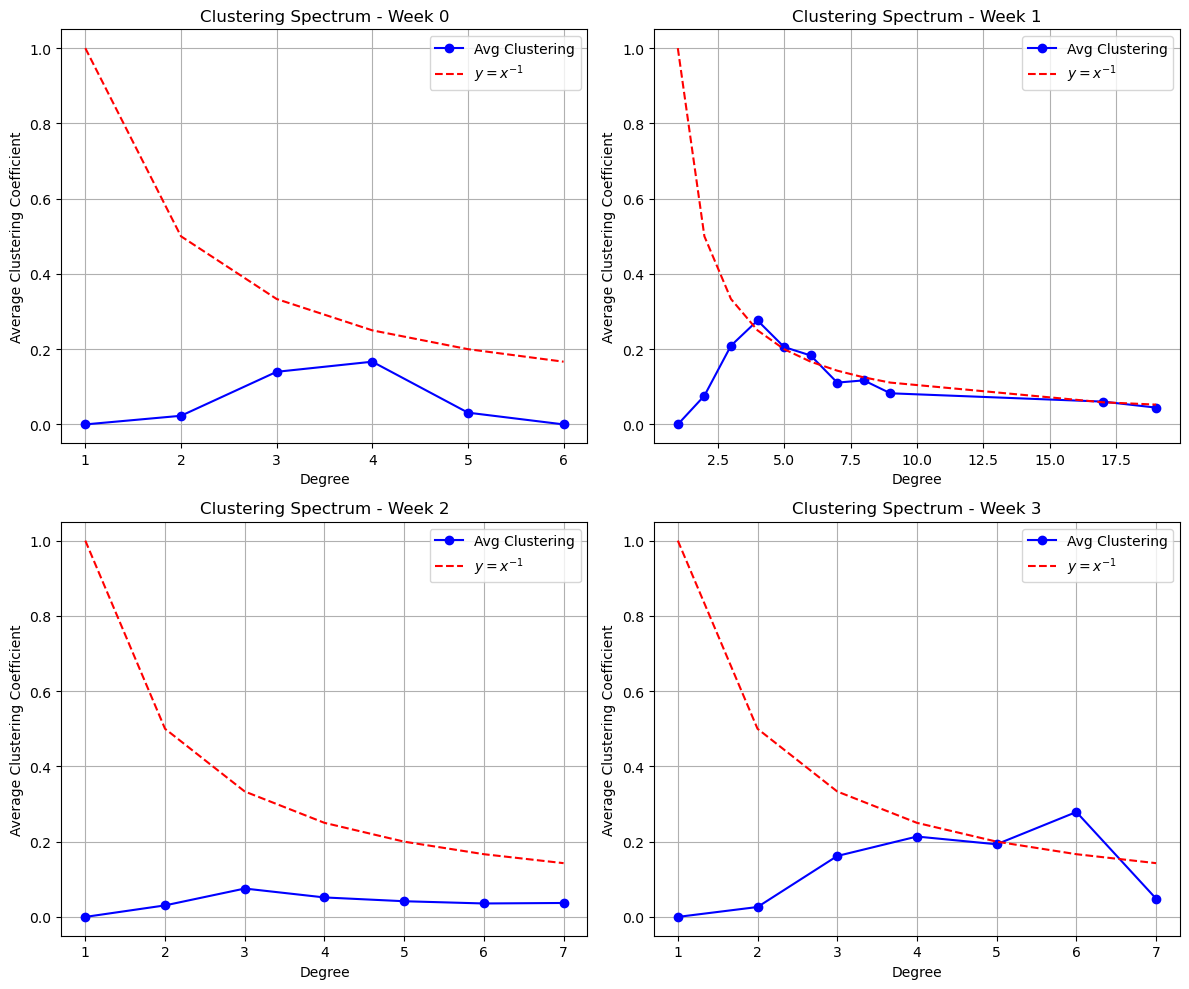

In [21]:
from collections import defaultdict

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

for i, week in enumerate(weeks):
    node_degrees = weekly_node_degrees[week]
    node_clustering = weekly_node_clustering[week]
    
    # Group clustering values by degree
    clustering_by_degree = defaultdict(list)
    for node, degree in node_degrees.items():
        clustering_by_degree[degree].append(node_clustering[node])
    
    # Compute average clustering per degree
    k_vals = sorted(clustering_by_degree.keys())
    avg_clustering = [np.mean(clustering_by_degree[k]) for k in k_vals]
    
    axs[i].plot(k_vals, avg_clustering, 'bo-', label="Avg Clustering")
    axs[i].plot(k_vals, [1/k for k in k_vals], 'r--', label=r"$y = x^{-1}$")
    
    axs[i].set_title(f"Clustering Spectrum - Week {week}")
    axs[i].set_xlabel("Degree")
    axs[i].set_ylabel("Average Clustering Coefficient")
    axs[i].grid(True)
    axs[i].legend()

plt.tight_layout()
plt.show()


Clustering coefficient doesn't seem to change across degrees, nor follow the expected power law. There are tighlthy knitted friend groups.

### Degree distribution at the macroscopic scale

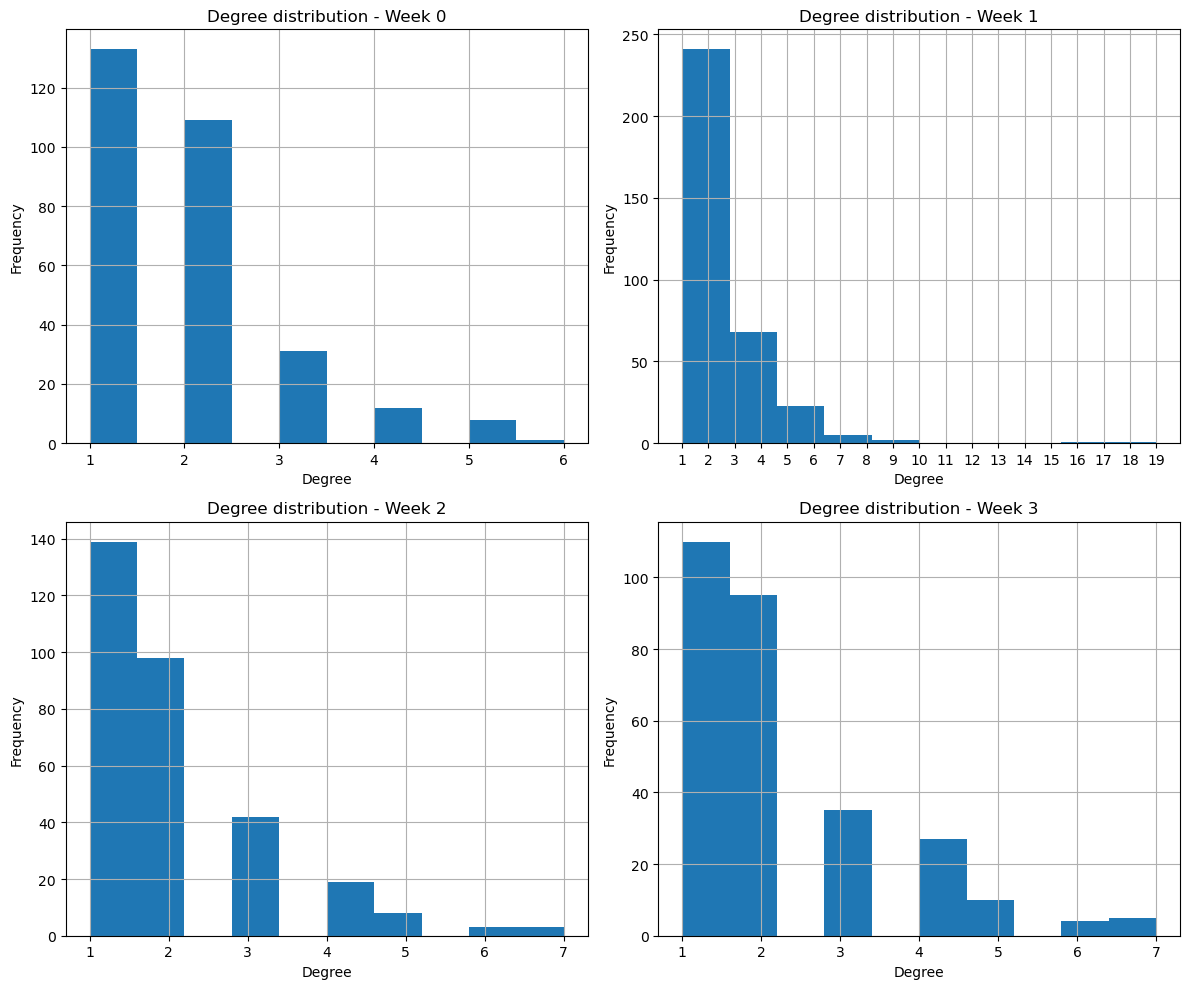

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

for i, week in enumerate(weeks):
    # Retrieve node degrees for the current week
    node_degrees = weekly_node_degrees[week]
    degrees = list(node_degrees.values())
    
    # Scatter plot for the current week in the appropriate subplot
    axs[i].hist(degrees)
    axs[i].set_xticks(range(min(degrees), max(degrees) + 1))
    axs[i].set_title(f"Degree distribution - Week {week}")
    axs[i].set_xlabel("Degree")
    axs[i].set_ylabel("Frequency")
    axs[i].grid(True)

plt.tight_layout()
plt.show()

We clearly see that the degree distribution of all weeks follow a power law. The only difference across weeks is that the degree range in week 1 is larger.

### Correlations

In [23]:
degree_assortativity_week = []
for week, G in graphs_by_week.items():
    # Compute degree assortativity
    assortativity = nx.degree_assortativity_coefficient(G)
    degree_assortativity_week.append({
        'week': week,
        'assortativity': assortativity
    })
degree_assortativity_week = pd.DataFrame(degree_assortativity_week)
degree_assortativity_week

week  assortativity
0     0       0.018200
1     1       0.096614
2     2       0.036932
3     3       0.107069

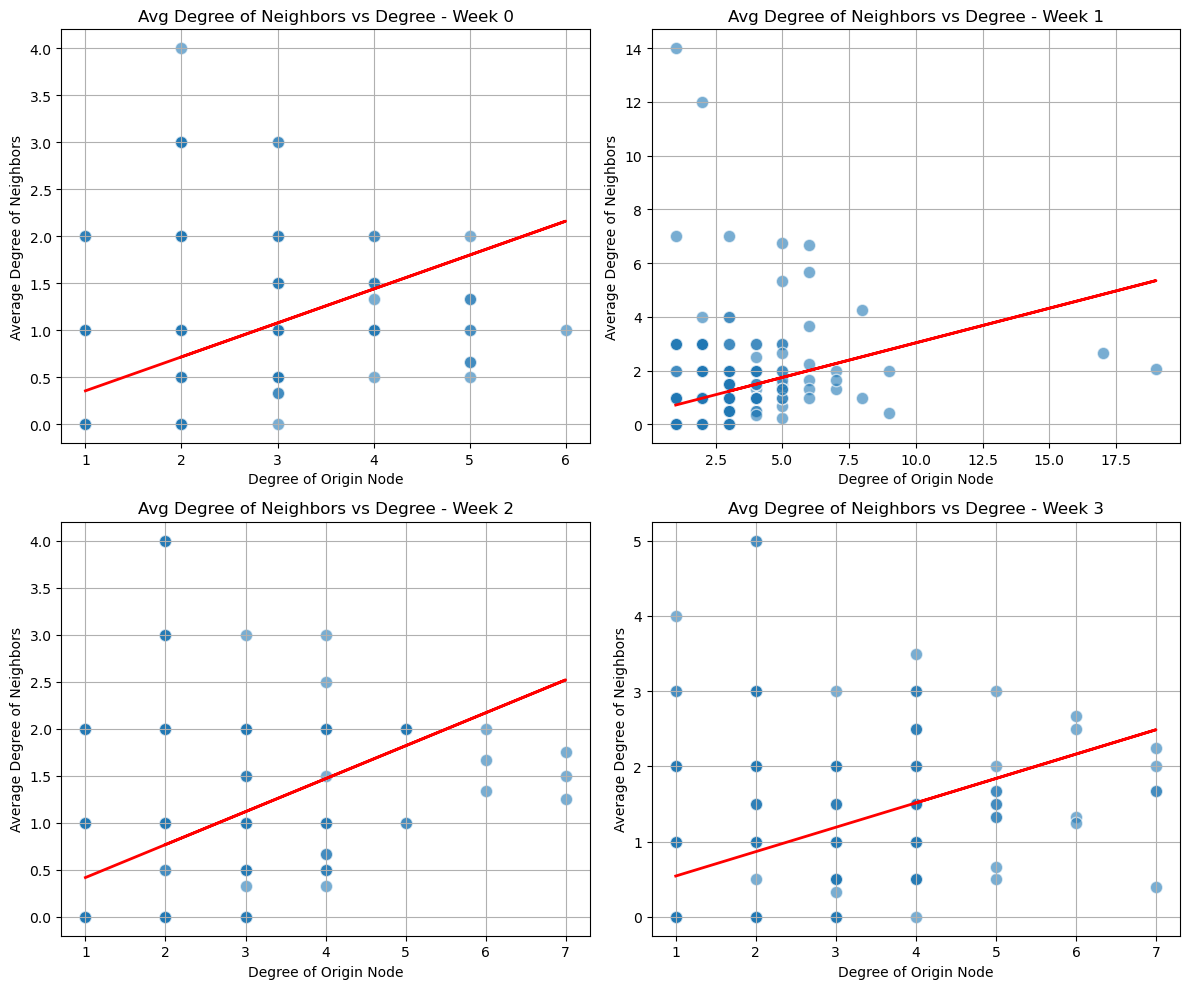

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

# Loop over the first four weeks (if available)
for i, week in enumerate(weeks):
    G = graphs_by_week[week]
    node_degrees = weekly_node_degrees[week]
    
    # Lists to store the degree of the origin node and average degree of neighbors
    origin_degrees = []
    avg_neighbor_degrees = []
    
    avg_neighbor_degree = nx.average_neighbor_degree(G)
    
    # Loop over each node in the graph
    for node in G.nodes():
        degree = node_degrees[node]  # Degree of the origin node
        avg_degree = avg_neighbor_degree[node]  # Average degree of neighbors
        
        origin_degrees.append(degree)
        avg_neighbor_degrees.append(avg_degree)
    
    # Convert lists to numpy arrays for regression
    X = np.array(origin_degrees).reshape(-1, 1)  # Reshaping for sklearn
    y = np.array(avg_neighbor_degrees)
    
    # Fit linear regression model
    model = LinearRegression()
    model.fit(X, y)
    
    # Get the regression line
    y_pred = model.predict(X)
    
    # Scatter plot for the current week in the appropriate subplot
    axs[i].scatter(origin_degrees, avg_neighbor_degrees, alpha=0.6, edgecolors="w", s=80)
    axs[i].plot(X, y_pred, color='red', linewidth=2)  # Plot the regression line in red
    
    axs[i].set_title(f"Avg Degree of Neighbors vs Degree - Week {week}")
    axs[i].set_xlabel("Degree of Origin Node")
    axs[i].set_ylabel("Average Degree of Neighbors")
    axs[i].grid(True)

plt.tight_layout()
plt.show()

Although the scatter plots don't look very informative, the linear regresion computed on top shows that the four graphs are assortative networks, the correlations are positive.

Nodes are connected to similar nodes to them.

## Conclusions

People in this network don't seem to be very connected, at least through calls. We could improve this analysis with more sources of communication data.

The groups that are present in this network form little clustered groups.

## References

https://www.nature.com/articles/s41597-019-0325-x 